# Install & Import Dependencies

In [1]:
!pip install jcopml -q
!pip install demoji -q
!pip install swifter -q
!pip install Sastrawi -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.2 MB/s eta 0:00:0000:010:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.8 MB/s eta 0:00:0000:01


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import re
import demoji
from nltk.corpus import stopwords
import swifter
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize 
from collections import Counter
from collections import defaultdict
from jcopml.plot import plot_missing_value, plot_correlation_matrix, plot_association_matrix
from wordcloud import WordCloud
from datetime import datetime

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Dataset

In [3]:
# url = 'hf://datasets/shobrunjb/skincare-product-review-indo-v2/pre-processing.csv'
url = 'https://raw.githubusercontent.com/Fake-Sentiment-Review-Detection-Spiill/spiill-data-and-utils/refs/heads/main/final%20dataset%206000-v2.csv'
df_reviews = pd.read_csv(url)
df_reviews.tail(3)

,username,rate,date,label,sentimen,reviews,produk
5997,eiswahyudi,3,2024-03-17,non,neutral,Pasar saham Indonesia menunjukkan tren yang st...,Masker Skintific
5998,dkusumo,5,2023-09-18,non,neutral,Penggunaan kendaraan listrik mulai diminati di...,Masker Skintific
5999,adisti,3,2023-09-11,non,neutral,Lumayan lancar dengan berjalan baik,Masker Skintific


# EDA + Preprocessing

In [4]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0    username  6000 non-null   object
 1   rate       6000 non-null   int64 
 2   date       6000 non-null   object
 3   label      6000 non-null   object
 4   sentimen   6000 non-null   object
 5   reviews    6000 non-null   object
 6   produk     6000 non-null   object
dtypes: int64(1), object(6)
memory usage: 328.2+ KB


In [5]:
df_reviews.nunique()

 username    5499
rate            5
date         5255
label           3
sentimen        3
reviews      5950
produk        238
dtype: int64

## Missing Value

,missing_value,%
username,0,0.0
rate,0,0.0
date,0,0.0
label,0,0.0
sentimen,0,0.0
reviews,0,0.0
produk,0,0.0


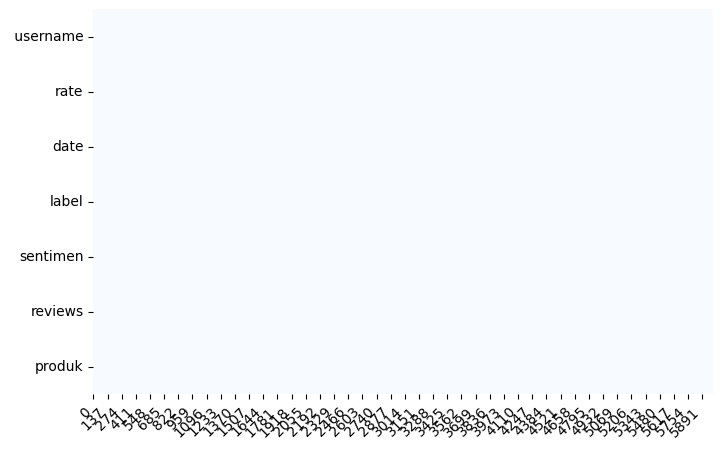

In [6]:
plot_missing_value(df_reviews, return_df=True, figsize=(8, 5))

## Descriptive

In [7]:
df_reviews.describe(exclude=['object']).T

,count,mean,std,min,25%,50%,75%,max
rate,6000.0,3.798,1.169512,1.0,3.0,4.0,5.0,5.0


In [8]:
df_reviews.describe(include=['object']).T

,count,unique,top,freq
username,6000,5499,cici selvi,11
date,6000,5255,2024-05-23 12:07,6
label,6000,3,trusted,3924
sentimen,6000,3,positive,3725
reviews,6000,5950,Investasi di sektor teknologi terus menunjukka...,4
produk,6000,238,Acnes Creamy Wash,929


## Duplicate

In [9]:
df_reviews.duplicated().sum()

0

In [10]:
df_reviews.reviews.duplicated().sum()

50

In [11]:
df_reviews[df_reviews.reviews.duplicated(keep=False)]

,username,rate,date,label,sentimen,reviews,produk
73,awrel,1,15-09-2021 8:49,trusted,negative,"Dulu pernah cobain produk ini, aku apply pagi ...",Acnes Powder
74,zefanyamonica,1,14-09-2021 5:59,trusted,negative,"Dulu pernah cobain produk ini, aku apply pagi ...",Acnes Powder
610,Adiansyah,4,08-09-2021 18:18,trusted,positive,"lembut di muka, busanya juga pas dan nggak bik...",Acnes Creamy Wash
612,missriviu,5,11-08-2021 17:09,trusted,positive,"lembut di muka, busanya juga pas dan nggak bik...",Acnes Creamy Wash
683,Gemma_evrard,4,29-10-2022 9:11,trusted,positive,untuk mukaku yg normal2 aja aku ngerasa fw ini...,Acnes Creamy Wash
...,...,...,...,...,...,...,...
5991,estionosusanti,2,2024-08-10,non,neutral,Pemerintah gencar mendorong program vaksinasi ...,Masker Skintific
5992,bharyanto,3,2024-04-25,non,neutral,Olahraga pagi mulai menjadi rutinitas banyak o...,Masker Skintific
5993,utamanarji,3,2024-08-21,non,neutral,Investasi di sektor teknologi terus menunjukka...,Masker Skintific
5994,faridakania,2,2024-07-30,non,neutral,Peran UMKM dalam perekonomian nasional semakin...,Masker Skintific


In [12]:
df_reviews.iloc[683]['reviews']

'untuk mukaku yg normal2 aja aku ngerasa fw ini gada efek sama sekali ya. tapi adekku yg berjerawat juga pakai ini, setelah 6 bulan pemakaian paket acnes lengkap, bener2 jerawatnya berkurang sih. sabunnya juga enak gada bau2 yg nyengat di idung. natural aja gitu.'

In [13]:
df_reviews[df_reviews.reviews == df_reviews.iloc[683]['reviews']]['reviews']

683    untuk mukaku yg normal2 aja aku ngerasa fw ini...
684    untuk mukaku yg normal2 aja aku ngerasa fw ini...
Name: reviews, dtype: object

In [14]:
print(df_reviews.shape)
df_reviews = df_reviews.drop_duplicates(subset=['reviews'], keep='first', inplace=False)
print(df_reviews.duplicated(subset=['reviews']).sum())
print(df_reviews.shape)

(6000, 7)
0
(5950, 7)


In [15]:
df_reviews

,username,rate,date,label,sentimen,reviews,produk
0,mtraandita,3,19-05-2024 01:36 PM,trusted,neutral,"Waktu smp aku pakai ss ini selama ±2 tahun, te...",Emina Sunscreen
1,Miftahuljahra,2,18-05-2024 06:38 AM,trusted,negative,Aku ga terlalu cocok pake produk ini terlebih ...,Emina Sunscreen
2,Marizka_nuril,3,18-05-2024 06:06 AM,trusted,neutral,"Sunscreen pertama aku sewaktu kenal skincare, ...",Emina Sunscreen
3,Denyul,3,17-05-2024 10:28 AM,trusted,neutral,Teksturnya agak watery gitu\nDiblendnya agak l...,Emina Sunscreen
4,anakusumaayu,3,16-05-2024 02:59 AM,trusted,neutral,"ini adalah suncreen pertamaku , dulu cocok ban...",Emina Sunscreen
...,...,...,...,...,...,...,...
5994,faridakania,2,2024-07-30,non,neutral,Peran UMKM dalam perekonomian nasional semakin...,Masker Skintific
5995,hasanwahyuni,1,2023-09-11,non,neutral,Penggunaan teknologi di Indonesia semakin berk...,Masker Skintific
5997,eiswahyudi,3,2024-03-17,non,neutral,Pasar saham Indonesia menunjukkan tren yang st...,Masker Skintific
5998,dkusumo,5,2023-09-18,non,neutral,Penggunaan kendaraan listrik mulai diminati di...,Masker Skintific


# Feature Engineering

In [16]:
df_reviews['reviews'].iloc[0]

"Waktu smp aku pakai ss ini selama ±2 tahun, terus aku stop selama covid karena ga pernah keluar. Pas coba pake lagi, tiba2 breakout parah banget sehari setelahnya, padahal exp product masih lama. Dari aman selama dua tahun, terus tiba-tiba ga cocok dan breakout parah yg jerawatan batu gitu. I don't know why, sepertinya kulitku jadi sensitif dengan fragrancenya. Tapi untuk yg kulit normal, ini oke oke aja kayanya. "

## Remove Link, Hashtag, Mention

In [17]:
def cleanUpTweet(txt):
    txt = re.sub(r'@[A-Za-z0-9_]+', '', txt) #Remove mentions
    txt = re.sub(r'#[A-Za-z0-9_]+', '', txt) #Remove hashtags
    txt = re.sub(r'RT ', '', txt) #Remove retweets
    txt = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', txt) #Remove urls
    return txt

def remove_emojis(text):
    txt = demoji.replace(text, '')
    return txt

df_reviews['no_link_hashtag_reviews'] = df_reviews['reviews'].apply(cleanUpTweet)
df_reviews['no_emojis_reviews'] = df_reviews['no_link_hashtag_reviews'].apply(remove_emojis)

df_reviews['no_emojis_reviews'].iloc[0]

"Waktu smp aku pakai ss ini selama ±2 tahun, terus aku stop selama covid karena ga pernah keluar. Pas coba pake lagi, tiba2 breakout parah banget sehari setelahnya, padahal exp product masih lama. Dari aman selama dua tahun, terus tiba-tiba ga cocok dan breakout parah yg jerawatan batu gitu. I don't know why, sepertinya kulitku jadi sensitif dengan fragrancenya. Tapi untuk yg kulit normal, ini oke oke aja kayanya. "

## Remove HTML Char

In [18]:
def removeHTMLChar(text):
    text = ' '.join(re.sub("([&][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    return text

df_reviews['no_html_reviews'] = df_reviews['no_emojis_reviews'].apply(removeHTMLChar)

df_reviews['no_html_reviews'].iloc[0]

"Waktu smp aku pakai ss ini selama ±2 tahun, terus aku stop selama covid karena ga pernah keluar. Pas coba pake lagi, tiba2 breakout parah banget sehari setelahnya, padahal exp product masih lama. Dari aman selama dua tahun, terus tiba-tiba ga cocok dan breakout parah yg jerawatan batu gitu. I don't know why, sepertinya kulitku jadi sensitif dengan fragrancenya. Tapi untuk yg kulit normal, ini oke oke aja kayanya."

## Remove All Special Character

In [19]:
def remove_text_special(text):
    text = text.replace('\t', " ").replace('\n', " ").replace(r'\u', " ").replace("\\", "")
    text = text.encode('ascii', 'replace').decode('ascii')
    text = ' '.join(re.sub(r"([@#&][A-Za-z0-9]+)|(\w+:\/\/\S+)", " ", text).split())
    return text.replace("http://", " ").replace("https://", " ")

df_reviews['no_special_char_reviews'] = df_reviews['no_html_reviews'].apply(remove_text_special)

df_reviews['no_special_char_reviews'].iloc[0]

"Waktu smp aku pakai ss ini selama ?2 tahun, terus aku stop selama covid karena ga pernah keluar. Pas coba pake lagi, tiba2 breakout parah banget sehari setelahnya, padahal exp product masih lama. Dari aman selama dua tahun, terus tiba-tiba ga cocok dan breakout parah yg jerawatan batu gitu. I don't know why, sepertinya kulitku jadi sensitif dengan fragrancenya. Tapi untuk yg kulit normal, ini oke oke aja kayanya."

## Remove Number

In [20]:
def removeNumbers(text):
    text = ''.join([i for i in text if not i.isdigit()])         
    return text

df_reviews['no_number_reviews'] = df_reviews['no_special_char_reviews'].apply(removeNumbers)

df_reviews['no_number_reviews'].iloc[0]

"Waktu smp aku pakai ss ini selama ? tahun, terus aku stop selama covid karena ga pernah keluar. Pas coba pake lagi, tiba breakout parah banget sehari setelahnya, padahal exp product masih lama. Dari aman selama dua tahun, terus tiba-tiba ga cocok dan breakout parah yg jerawatan batu gitu. I don't know why, sepertinya kulitku jadi sensitif dengan fragrancenya. Tapi untuk yg kulit normal, ini oke oke aja kayanya."

## Remove Punctuation

In [21]:
def remove_punctuation(txt):
  txt = re.sub(r'[^\w\s]', ' ', txt)
  return txt

df_reviews['no_punct_reviews'] = df_reviews['no_number_reviews'].apply(remove_punctuation)

df_reviews['no_punct_reviews'].iloc[0]

'Waktu smp aku pakai ss ini selama   tahun  terus aku stop selama covid karena ga pernah keluar  Pas coba pake lagi  tiba breakout parah banget sehari setelahnya  padahal exp product masih lama  Dari aman selama dua tahun  terus tiba tiba ga cocok dan breakout parah yg jerawatan batu gitu  I don t know why  sepertinya kulitku jadi sensitif dengan fragrancenya  Tapi untuk yg kulit normal  ini oke oke aja kayanya '

## Remove Whitespace

In [22]:
def remove_whitespace_LT(text):
    return text.strip()

def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

def spell(word):
    if re.search(r'([a-zA-Z])\1{2,}', word):
        rword = re.sub(r'([a-zA-Z])\1{2,}','\1', word)
        return rword
    else:
        return word

df_reviews['no_whitespace_reviews_reviews'] = df_reviews['no_punct_reviews'].apply(remove_whitespace_LT)
df_reviews['no_whitespace_reviews_reviews'] = df_reviews['no_whitespace_reviews_reviews'].apply(remove_whitespace_multiple)
df_reviews['no_whitespace_reviews_reviews'] = df_reviews['no_whitespace_reviews_reviews'].apply(spell)

df_reviews['no_whitespace_reviews_reviews'].iloc[0]

'Waktu smp aku pakai ss ini selama tahun terus aku stop selama covid karena ga pernah keluar Pas coba pake lagi tiba breakout parah banget sehari setelahnya padahal exp product masih lama Dari aman selama dua tahun terus tiba tiba ga cocok dan breakout parah yg jerawatan batu gitu I don t know why sepertinya kulitku jadi sensitif dengan fragrancenya Tapi untuk yg kulit normal ini oke oke aja kayanya'

## To Lowercase

In [23]:
df_reviews['lowercase_reviews'] = df_reviews['no_whitespace_reviews_reviews'].apply(lambda item: str(item).lower())

df_reviews['lowercase_reviews'].iloc[0]

'waktu smp aku pakai ss ini selama tahun terus aku stop selama covid karena ga pernah keluar pas coba pake lagi tiba breakout parah banget sehari setelahnya padahal exp product masih lama dari aman selama dua tahun terus tiba tiba ga cocok dan breakout parah yg jerawatan batu gitu i don t know why sepertinya kulitku jadi sensitif dengan fragrancenya tapi untuk yg kulit normal ini oke oke aja kayanya'

## Tokenize

In [24]:
def word_tokenize_wrapper(text):
    return word_tokenize(text)
    
def tokenize(word):
  word = word.split(" ")
  return word

df_reviews['tokens_reviews'] = df_reviews['lowercase_reviews'].apply(word_tokenize_wrapper)

df_reviews['tokens_reviews'].iloc[0]

['waktu',
 'smp',
 'aku',
 'pakai',
 'ss',
 'ini',
 'selama',
 'tahun',
 'terus',
 'aku',
 'stop',
 'selama',
 'covid',
 'karena',
 'ga',
 'pernah',
 'keluar',
 'pas',
 'coba',
 'pake',
 'lagi',
 'tiba',
 'breakout',
 'parah',
 'banget',
 'sehari',
 'setelahnya',
 'padahal',
 'exp',
 'product',
 'masih',
 'lama',
 'dari',
 'aman',
 'selama',
 'dua',
 'tahun',
 'terus',
 'tiba',
 'tiba',
 'ga',
 'cocok',
 'dan',
 'breakout',
 'parah',
 'yg',
 'jerawatan',
 'batu',
 'gitu',
 'i',
 'don',
 't',
 'know',
 'why',
 'sepertinya',
 'kulitku',
 'jadi',
 'sensitif',
 'dengan',
 'fragrancenya',
 'tapi',
 'untuk',
 'yg',
 'kulit',
 'normal',
 'ini',
 'oke',
 'oke',
 'aja',
 'kayanya']

In [25]:
word_count = defaultdict(int)
for tokens in df_reviews['tokens_reviews']:
    for token in tokens:
       word_count[token] += 1

word_count_df = pd.DataFrame({"key": word_count.keys(), "count": word_count.values()})
word_count_df_sort = word_count_df.sort_values('count', axis=0, ascending=False, inplace=False)
word_count_df_sort.head(20)

,key,count
34,dan,4596
5,ini,4551
2,aku,3735
71,di,2989
22,banget,2804
68,yang,2673
50,tapi,2139
12,ga,2013
144,juga,1889
52,kulit,1808


## Stopword Removal

In [26]:
list_stopwords = stopwords.words('indonesian')
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo', 
                       'kalo', 'amp', 'biar', 'bikin', 'bilang', 
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih', 
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya', 
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't', 
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       'yah', # extend stopword 
                      'banget', 'pakai', 'pake']) # dominant word

stopword_url = 'https://raw.githubusercontent.com/Fake-Sentiment-Review-Detection-Spiill/spiill-data-and-utils/refs/heads/main/stopwords.txt'

txt_stopword = pd.read_csv(stopword_url, names= ["stopwords"], header = None)
list_stopwords.extend(txt_stopword["stopwords"][0].split(' '))
list_stopwords = set(list_stopwords)
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]
    
df_reviews['no_stopwords_reviews'] = df_reviews['tokens_reviews'].apply(stopwords_removal) 

df_reviews['no_stopwords_reviews'].iloc[0]

['smp',
 'stop',
 'covid',
 'pas',
 'coba',
 'breakout',
 'parah',
 'sehari',
 'setelahnya',
 'exp',
 'product',
 'aman',
 'cocok',
 'breakout',
 'parah',
 'jerawatan',
 'batu',
 'know',
 'kulitku',
 'sensitif',
 'fragrancenya',
 'kulit',
 'normal',
 'oke',
 'oke',
 'kayanya']

In [27]:
word_count = defaultdict(int)
for tokens in df_reviews['no_stopwords_reviews']:
    for token in tokens:
       word_count[token] += 1

word_count_df = pd.DataFrame({"key": word_count.keys(), "count": word_count.values()})
word_count_df_sort = word_count_df.sort_values('count', axis=0, ascending=False, inplace=False)
word_count_df_sort.head(20)

,key,count
19,kulit,1808
12,cocok,1329
147,bagus,1250
23,produk,1243
37,suka,1135
367,kering,974
3,pas,968
131,beli,887
433,rambut,849
56,lumayan,737


## Stemming

In [28]:
df_normalized = pd.DataFrame(df_reviews['reviews'])
df_normalized['cleaned_reviews'] = df_reviews['lowercase_reviews']
df_normalized['tokens_reviews'] = df_reviews['tokens_reviews']
df_normalized['no_stopwords_tokens_reviews'] = df_reviews['no_stopwords_reviews']

normalizad_word = df_normalized

normalizad_word_dict = {}

for index, row in normalizad_word.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1]  

def normalized_term(document):
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]

df_reviews['normalized_reviews'] = df_reviews['no_stopwords_reviews'].apply(normalized_term)

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in df_reviews['normalized_reviews']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '
            
print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])
    
print(term_dict)
print("------------------------")


# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

df_reviews['stemmed_reviews'] = df_reviews['normalized_reviews'].swifter.apply(get_stemmed_term)

10386
------------------------
smp : smp
stop : stop
covid : covid
pas : pas
coba : coba
breakout : breakout
parah : parah
sehari : hari
setelahnya : telah
exp : exp
product : product
aman : aman
cocok : cocok
jerawatan : jerawat
batu : batu
know : know
kulitku : kulit
sensitif : sensitif
fragrancenya : fragrancenya
kulit : kulit
normal : normal
oke : oke
kayanya : kaya
produk : produk
muka : muka
oily : oily
skin : skin
dipake : dipake
langsungkeluar : langsungkeluar
jerawatnya : jerawat
dryskin : dryskin
jerawat : jerawat
sunscreen : sunscreen
kenal : kenal
skincare : skincare
first : first
apply : apply
suka : suka
fragrance : fragrance
kencang : kencang
teksturnya : tekstur
gel : gel
gampang : gampang
repurchase : repurchase
karna : karna
harganya : harga
affordable : affordable
sekolah : sekolah
hasil : hasil
pemakaian : pakai
kyk : kyk
ngerasa : ngerasa
keringettan : keringettan
huhu : huhu
watery : watery
diblendnya : diblendnya
lumayan : lumayan
usaha : usaha
kerasa : rasa
pana

Pandas Apply:   0%|          | 0/5950 [00:00<?, ?it/s]

# Second EDA (Checking data after processing)

In [29]:
df_reviews.tail(3)

,username,rate,date,label,sentimen,reviews,produk,no_link_hashtag_reviews,no_emojis_reviews,no_html_reviews,no_special_char_reviews,no_number_reviews,no_punct_reviews,no_whitespace_reviews_reviews,lowercase_reviews,tokens_reviews,no_stopwords_reviews,normalized_reviews,stemmed_reviews
5997,eiswahyudi,3,2024-03-17,non,neutral,Pasar saham Indonesia menunjukkan tren yang st...,Masker Skintific,Pasar saham Indonesia menunjukkan tren yang st...,Pasar saham Indonesia menunjukkan tren yang st...,Pasar saham Indonesia menunjukkan tren yang st...,Pasar saham Indonesia menunjukkan tren yang st...,Pasar saham Indonesia menunjukkan tren yang st...,Pasar saham Indonesia menunjukkan tren yang st...,Pasar saham Indonesia menunjukkan tren yang st...,pasar saham indonesia menunjukkan tren yang st...,"[pasar, saham, indonesia, menunjukkan, tren, y...","[pasar, saham, indonesia, tren, stabil]","[pasar, saham, indonesia, tren, stabil]","[pasar, saham, indonesia, tren, stabil]"
5998,dkusumo,5,2023-09-18,non,neutral,Penggunaan kendaraan listrik mulai diminati di...,Masker Skintific,Penggunaan kendaraan listrik mulai diminati di...,Penggunaan kendaraan listrik mulai diminati di...,Penggunaan kendaraan listrik mulai diminati di...,Penggunaan kendaraan listrik mulai diminati di...,Penggunaan kendaraan listrik mulai diminati di...,Penggunaan kendaraan listrik mulai diminati di...,Penggunaan kendaraan listrik mulai diminati di...,penggunaan kendaraan listrik mulai diminati di...,"[penggunaan, kendaraan, listrik, mulai, dimina...","[penggunaan, kendaraan, listrik, diminati, per...","[penggunaan, kendaraan, listrik, diminati, per...","[guna, kendara, listrik, mati, kota]"
5999,adisti,3,2023-09-11,non,neutral,Lumayan lancar dengan berjalan baik,Masker Skintific,Lumayan lancar dengan berjalan baik,Lumayan lancar dengan berjalan baik,Lumayan lancar dengan berjalan baik,Lumayan lancar dengan berjalan baik,Lumayan lancar dengan berjalan baik,Lumayan lancar dengan berjalan baik,Lumayan lancar dengan berjalan baik,lumayan lancar dengan berjalan baik,"[lumayan, lancar, dengan, berjalan, baik]","[lumayan, lancar, berjalan]","[lumayan, lancar, berjalan]","[lumayan, lancar, jalan]"


## Duplicate

In [30]:
print(f'lowercase_reviews (cleaned)\t: {df_reviews.normalized_reviews.duplicated().sum()}')
print(f'tokens_reviews (cleaned)\t: {df_reviews.tokens_reviews.duplicated().sum()}')
print(f'normalized_reviews (cleaned)\t: {df_reviews.normalized_reviews.duplicated().sum()}')
print(f'stemmed_reviews (cleaned)\t: {df_reviews.stemmed_reviews.duplicated().sum()}')

lowercase_reviews (cleaned)	: 29
tokens_reviews (cleaned)	: 14
normalized_reviews (cleaned)	: 29
stemmed_reviews (cleaned)	: 32


In [31]:
df_reviews[df_reviews.stemmed_reviews.duplicated(keep=False)]

,username,rate,date,label,sentimen,reviews,produk,no_link_hashtag_reviews,no_emojis_reviews,no_html_reviews,no_special_char_reviews,no_number_reviews,no_punct_reviews,no_whitespace_reviews_reviews,lowercase_reviews,tokens_reviews,no_stopwords_reviews,normalized_reviews,stemmed_reviews
951,mayuhan01,5,2024-05-23 12:31,fake,positive,BAGUS,The Originote Lip Oil Serum - Lip Treatment Se...,BAGUS,BAGUS,BAGUS,BAGUS,BAGUS,BAGUS,BAGUS,bagus,[bagus],[bagus],[bagus],[bagus]
953,agismaulana000,5,2024-05-23 11:12,fake,positive,Bagusss,The Originote Cicamide Facial Cleanser - Face ...,Bagusss,Bagusss,Bagusss,Bagusss,Bagusss,Bagusss,Bagu,bagu,[bagu],[bagu],[bagu],[bagu]
956,maharaniariana,5,2024-05-23 11:53,fake,positive,Bagussssssss,The Originote Eye Serum - Eye Treatment Eye Cr...,Bagussssssss,Bagussssssss,Bagussssssss,Bagussssssss,Bagussssssss,Bagussssssss,Bagu,bagu,[bagu],[bagu],[bagu],[bagu]
961,mhayarahyapennyak,5,2024-05-23 12:07,fake,positive,sangat bagus,The Originote Hyalurose Micellar Water - 300ml...,sangat bagus,sangat bagus,sangat bagus,sangat bagus,sangat bagus,sangat bagus,sangat bagus,sangat bagus,"[sangat, bagus]",[bagus],[bagus],[bagus]
1086,rosidaf_12,5,2024-05-23 10:54,fake,positive,Bagus,Azarine Calm My Acne Sunscreen Moisturiser SPF...,Bagus,Bagus,Bagus,Bagus,Bagus,Bagus,Bagus,bagus,[bagus],[bagus],[bagus],[bagus]
1112,lisaamalia123,5,2024-05-23 9:34,non,positive,Semoga cocok,[GEL] Azarine Hydrasoothe Sunscreen Gel SPF45 ...,Semoga cocok,Semoga cocok,Semoga cocok,Semoga cocok,Semoga cocok,Semoga cocok,Semoga cocok,semoga cocok,"[semoga, cocok]","[semoga, cocok]","[semoga, cocok]","[moga, cocok]"
1168,g_lbcllpyw,4,2024-05-22 21:40,fake,positive,Cocok,[Azarine x Marvel] Radiant Luminous Serum 20ml,Cocok,Cocok,Cocok,Cocok,Cocok,Cocok,Cocok,cocok,[cocok],[cocok],[cocok],[cocok]
1198,h*****m,5,2024-05-22 21:08,non,positive,Terimakasih,BROMEN Brightening Soap - Sabun Cuci Muka Pemu...,Terimakasih,Terimakasih,Terimakasih,Terimakasih,Terimakasih,Terimakasih,Terimakasih,terimakasih,[terimakasih],[terimakasih],[terimakasih],[terimakasih]
1215,fahrulfananie,5,2024-05-22 14:36,fake,positive,bagusss,Bromen Paket Lengkap Sabun dan Serum Paket Bri...,bagusss,bagusss,bagusss,bagusss,bagusss,bagusss,bagu,bagu,[bagu],[bagu],[bagu],[bagu]
1217,arisstiawan.,5,2024-05-22 14:16,fake,positive,alhamdulillah cocok,BROMEN New 7x Ceramide Moisturizer Skin Moist ...,alhamdulillah cocok,alhamdulillah cocok,alhamdulillah cocok,alhamdulillah cocok,alhamdulillah cocok,alhamdulillah cocok,alhamdulillah cocok,alhamdulillah cocok,"[alhamdulillah, cocok]",[cocok],[cocok],[cocok]


In [32]:
print(df_reviews.shape)
df_reviews = df_reviews.drop_duplicates(subset=['stemmed_reviews'], keep=False, inplace=False)
print(df_reviews.duplicated(subset=['stemmed_reviews']).sum())
print(df_reviews.shape)

(5950, 19)
0
(5900, 19)


In [33]:
df_reviews[df_reviews.stemmed_reviews.duplicated(keep=False)]

,username,rate,date,label,sentimen,reviews,produk,no_link_hashtag_reviews,no_emojis_reviews,no_html_reviews,no_special_char_reviews,no_number_reviews,no_punct_reviews,no_whitespace_reviews_reviews,lowercase_reviews,tokens_reviews,no_stopwords_reviews,normalized_reviews,stemmed_reviews


## Wordcloud

In [34]:
df_reviews.head(1)

,username,rate,date,label,sentimen,reviews,produk,no_link_hashtag_reviews,no_emojis_reviews,no_html_reviews,no_special_char_reviews,no_number_reviews,no_punct_reviews,no_whitespace_reviews_reviews,lowercase_reviews,tokens_reviews,no_stopwords_reviews,normalized_reviews,stemmed_reviews
0,mtraandita,3,19-05-2024 01:36 PM,trusted,neutral,"Waktu smp aku pakai ss ini selama ±2 tahun, te...",Emina Sunscreen,"Waktu smp aku pakai ss ini selama ±2 tahun, te...","Waktu smp aku pakai ss ini selama ±2 tahun, te...","Waktu smp aku pakai ss ini selama ±2 tahun, te...","Waktu smp aku pakai ss ini selama ?2 tahun, te...","Waktu smp aku pakai ss ini selama ? tahun, ter...",Waktu smp aku pakai ss ini selama tahun ter...,Waktu smp aku pakai ss ini selama tahun terus ...,waktu smp aku pakai ss ini selama tahun terus ...,"[waktu, smp, aku, pakai, ss, ini, selama, tahu...","[smp, stop, covid, pas, coba, breakout, parah,...","[smp, stop, covid, pas, coba, breakout, parah,...","[smp, stop, covid, pas, coba, breakout, parah,..."


## Positive

6230


Text(0.5, 1.0, '\nPOSITIVE\n')

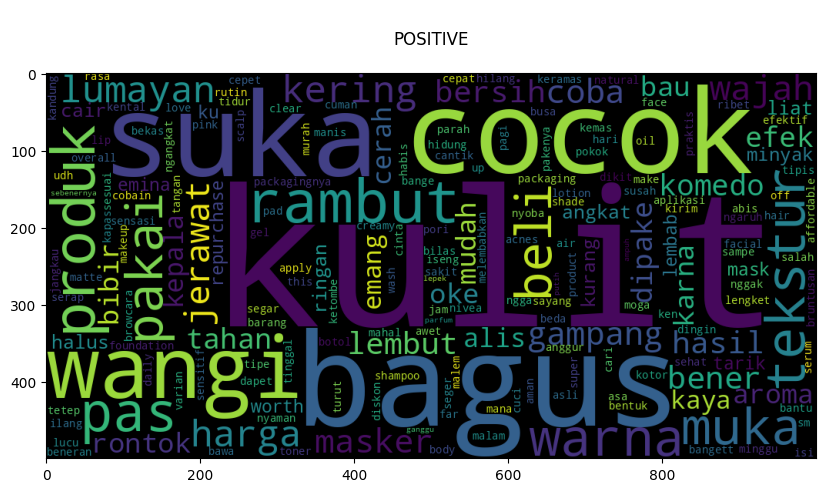

In [37]:
word_list = []
for text in df_reviews[df_reviews['sentimen']=='positive']['stemmed_reviews']:
  for word in text:
    if word.isnumeric() == False:
      word_list.append(word)
x = Counter(word_list)
print(len(x))
d = {k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('\nPOSITIVE\n')

## Neutral

3468


Text(0.5, 1.0, '\nNEUTRAL\n')

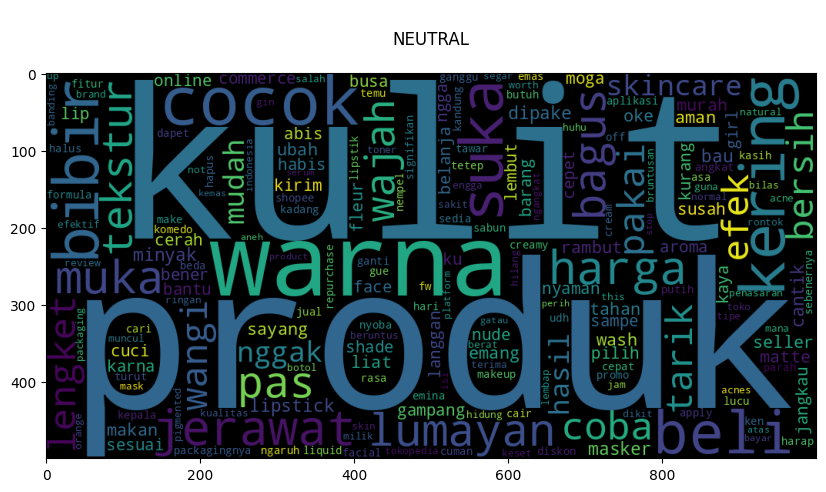

In [45]:
word_list = []
for text in df_reviews[df_reviews['sentimen']=='neutral']['stemmed_reviews']:
  for word in text:
    if word.isnumeric() == False:
      word_list.append(word)
x = Counter(word_list)
print(len(x))
d = {k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('\nNEUTRAL\n')

## Negative

2732


Text(0.5, 1.0, '\nNEGATIVE\n')

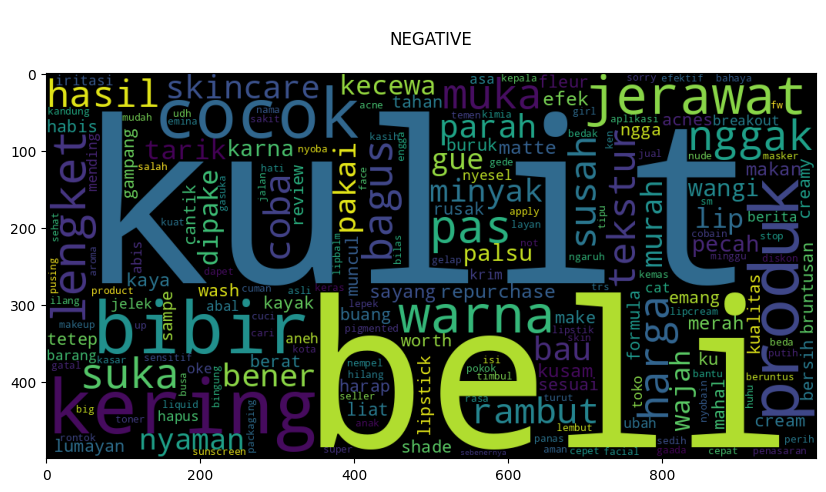

In [46]:
word_list = []
for text in df_reviews[df_reviews['sentimen']=='negative']['stemmed_reviews']:
  for word in text:
    if word.isnumeric() == False:
      word_list.append(word)
x = Counter(word_list)
print(len(x))
d = {k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('\nNEGATIVE\n')

## Trusted

6856


Text(0.5, 1.0, '\nTRUSTED\n')

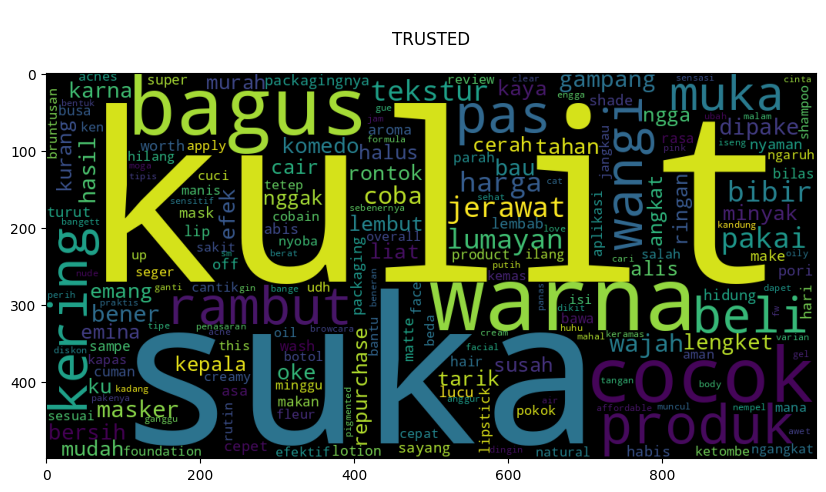

In [47]:
word_list = []
for text in df_reviews[df_reviews['label']=='trusted']['stemmed_reviews']:
  for word in text:
    if word.isnumeric() == False:
      word_list.append(word)
x = Counter(word_list)
print(len(x))
d = {k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('\nTRUSTED\n')

## Non

2539


Text(0.5, 1.0, '\nNON\n')

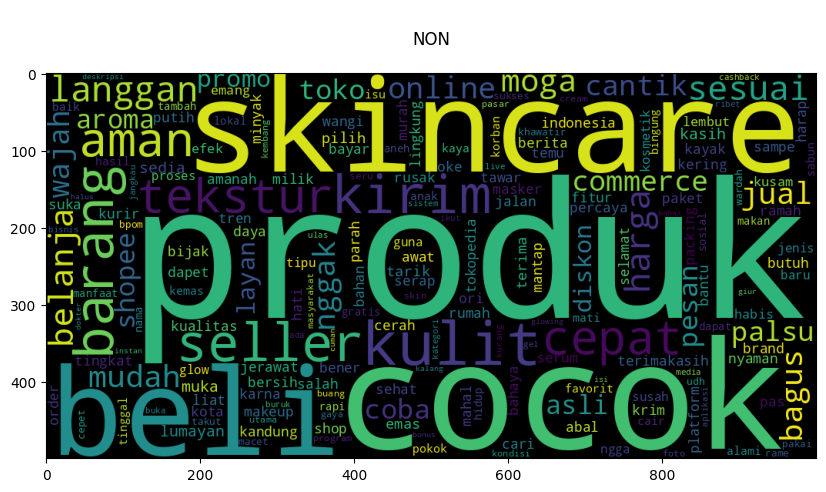

In [48]:
word_list = []
for text in df_reviews[df_reviews['label']=='non']['stemmed_reviews']:
  for word in text:
    if word.isnumeric() == False:
      word_list.append(word)
x = Counter(word_list)
print(len(x))
d = {k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('\nNON\n')

## Fake

1617


Text(0.5, 1.0, '\nNON\n')

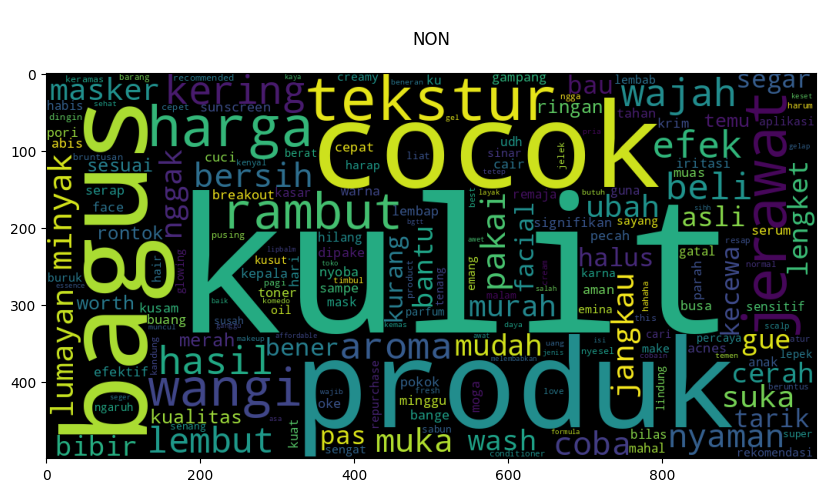

In [49]:
word_list = []
for text in df_reviews[df_reviews['label']=='fake']['stemmed_reviews']:
  for word in text:
    if word.isnumeric() == False:
      word_list.append(word)
x = Counter(word_list)
print(len(x))
d = {k: v for k, v in sorted(x.items(), key=lambda item: item[0], reverse=False)}
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(d)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('\nNON\n')

# Export to CSV

In [53]:
# Mendapatkan tanggal dan waktu saat ini
current_datetime = datetime.now()

# Format tanggal dan waktu sesuai keinginan (DD_MM_YY_HH_MM)
formatted_datetime = current_datetime.strftime("%d_%m_%y_%H_%M")

# Membuat nama file dinamis
filename = f'spiill_reviews_preprocessed_{formatted_datetime}.csv'

# Export ke CSV
df_reviews.to_csv(filename, index=False, encoding='utf-8')

pd.read_csv(f'/kaggle/working/spiill_reviews_preprocessed_{formatted_datetime}.csv')

,username,rate,date,label,sentimen,reviews,produk,no_link_hashtag_reviews,no_emojis_reviews,no_html_reviews,no_special_char_reviews,no_number_reviews,no_punct_reviews,no_whitespace_reviews_reviews,lowercase_reviews,tokens_reviews,no_stopwords_reviews,normalized_reviews,stemmed_reviews
0,mtraandita,3,19-05-2024 01:36 PM,trusted,neutral,"Waktu smp aku pakai ss ini selama ±2 tahun, te...",Emina Sunscreen,"Waktu smp aku pakai ss ini selama ±2 tahun, te...","Waktu smp aku pakai ss ini selama ±2 tahun, te...","Waktu smp aku pakai ss ini selama ±2 tahun, te...","Waktu smp aku pakai ss ini selama ?2 tahun, te...","Waktu smp aku pakai ss ini selama ? tahun, ter...",Waktu smp aku pakai ss ini selama tahun ter...,Waktu smp aku pakai ss ini selama tahun terus ...,waktu smp aku pakai ss ini selama tahun terus ...,"['waktu', 'smp', 'aku', 'pakai', 'ss', 'ini', ...","['smp', 'stop', 'covid', 'pas', 'coba', 'break...","['smp', 'stop', 'covid', 'pas', 'coba', 'break...","['smp', 'stop', 'covid', 'pas', 'coba', 'break..."
1,Miftahuljahra,2,18-05-2024 06:38 AM,trusted,negative,Aku ga terlalu cocok pake produk ini terlebih ...,Emina Sunscreen,Aku ga terlalu cocok pake produk ini terlebih ...,Aku ga terlalu cocok pake produk ini terlebih ...,Aku ga terlalu cocok pake produk ini terlebih ...,Aku ga terlalu cocok pake produk ini terlebih ...,Aku ga terlalu cocok pake produk ini terlebih ...,Aku ga terlalu cocok pake produk ini terlebih ...,Aku ga terlalu cocok pake produk ini terlebih ...,aku ga terlalu cocok pake produk ini terlebih ...,"['aku', 'ga', 'terlalu', 'cocok', 'pake', 'pro...","['cocok', 'produk', 'muka', 'oily', 'skin', 'd...","['cocok', 'produk', 'muka', 'oily', 'skin', 'd...","['cocok', 'produk', 'muka', 'oily', 'skin', 'd..."
2,Marizka_nuril,3,18-05-2024 06:06 AM,trusted,neutral,"Sunscreen pertama aku sewaktu kenal skincare, ...",Emina Sunscreen,"Sunscreen pertama aku sewaktu kenal skincare, ...","Sunscreen pertama aku sewaktu kenal skincare, ...","Sunscreen pertama aku sewaktu kenal skincare, ...","Sunscreen pertama aku sewaktu kenal skincare, ...","Sunscreen pertama aku sewaktu kenal skincare, ...",Sunscreen pertama aku sewaktu kenal skincare ...,Sunscreen pertama aku sewaktu kenal skincare f...,sunscreen pertama aku sewaktu kenal skincare f...,"['sunscreen', 'pertama', 'aku', 'sewaktu', 'ke...","['sunscreen', 'kenal', 'skincare', 'first', 'a...","['sunscreen', 'kenal', 'skincare', 'first', 'a...","['sunscreen', 'kenal', 'skincare', 'first', 'a..."
3,Denyul,3,17-05-2024 10:28 AM,trusted,neutral,Teksturnya agak watery gitu\nDiblendnya agak l...,Emina Sunscreen,Teksturnya agak watery gitu\nDiblendnya agak l...,Teksturnya agak watery gitu\nDiblendnya agak l...,Teksturnya agak watery gitu Diblendnya agak lu...,Teksturnya agak watery gitu Diblendnya agak lu...,Teksturnya agak watery gitu Diblendnya agak lu...,Teksturnya agak watery gitu Diblendnya agak lu...,Teksturnya agak watery gitu Diblendnya agak lu...,teksturnya agak watery gitu diblendnya agak lu...,"['teksturnya', 'agak', 'watery', 'gitu', 'dibl...","['teksturnya', 'watery', 'diblendnya', 'lumaya...","['teksturnya', 'watery', 'diblendnya', 'lumaya...","['tekstur', 'watery', 'diblendnya', 'lumayan',..."
4,anakusumaayu,3,16-05-2024 02:59 AM,trusted,neutral,"ini adalah suncreen pertamaku , dulu cocok ban...",Emina Sunscreen,"ini adalah suncreen pertamaku , dulu cocok ban...","ini adalah suncreen pertamaku , dulu cocok ban...","ini adalah suncreen pertamaku , dulu cocok ban...","ini adalah suncreen pertamaku , dulu cocok ban...","ini adalah suncreen pertamaku , dulu cocok ban...",ini adalah suncreen pertamaku dulu cocok ban...,ini adalah suncreen pertamaku dulu cocok bange...,ini adalah suncreen pertamaku dulu cocok bange...,"['ini', 'adalah', 'suncreen', 'pertamaku', 'du...","['suncreen', 'pertamaku', 'cocok', 'harganya',...","['suncreen', 'pertamaku', 'cocok', 'harganya',...","['suncreen', 'pertama', 'cocok', 'harga', 'fri..."
...,...,...,...,...,...,...,...,...,...,...,...,...,..